In [4]:
# Restricted Boltzmann Machines for Signals and Processes Dominated by Brownian Motion
#  
# We want to be able to simulate real BM signals with some fidelity, utilize the network for filtering 
# (e.g. by thresholding weights), and detect changepoints in BM characteristics and mean displacement
#
# Author: theScinder
# Consider this work to be CC NC BY SA www.thescinder.com for the time being.
# 


#Import packages 
import numpy as np
#for tic-toc funcitonality
import time

#plotting imports
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#for estimating PSDs
from scipy.signal import welch


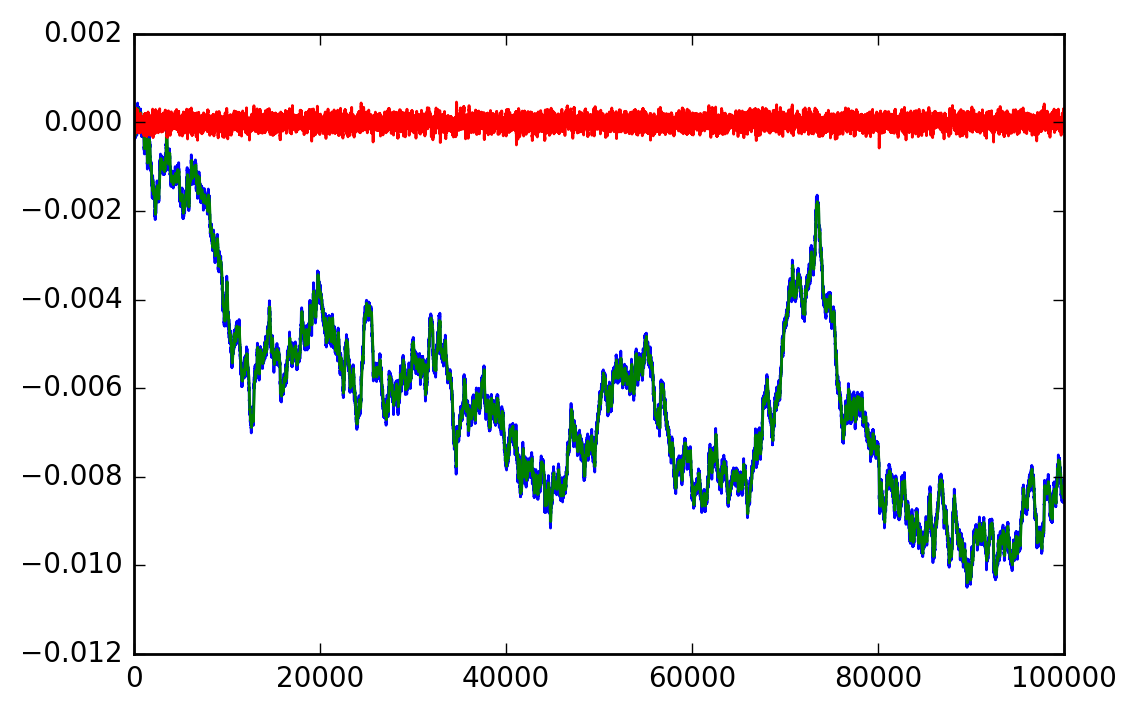

In [2]:
#setup the sampling frequency and time step
fs = 2**14
dt = 1/fs

# seed the PRNG
np.random.seed(1)
# accumulate the output of the random number generator
myBrownian = dt*np.cumsum(np.random.randn(100000))
#myTest = dt*np.random.normal(0,1, 1000)
#print(np.shape(myTest))

# To get a damped signal, take the difference of the original signal and the moving average of the same signal.
# There's no fancy theory on the choices I made below, I just attempted to get a trace that looks like the 
# signals I'm used to from biophysics

avgWindow = 50
myAvgSig = myBrownian*0
for c in range(avgWindow,len(myBrownian)):
    myAvgSig[c] = np.mean(myBrownian[c-avgWindow:c])

    
#Che
myDampSig = myBrownian-myAvgSig
plt.figure()
plt.plot(myBrownian)
plt.plot(myAvgSig)
plt.plot(myDampSig)
plt.show()


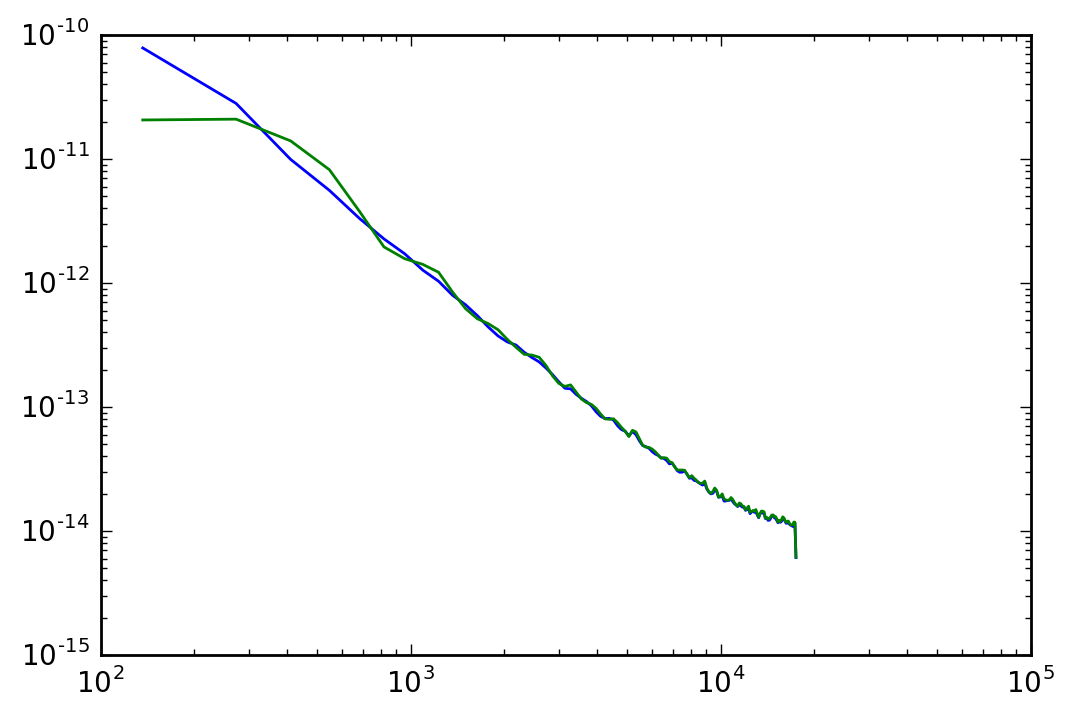

In [3]:
myF,myBPSD = welch(myBrownian,fs=1/dt)
#myF,myAPSD = welch(myAvgSig,fs=1/dt)
myF,myDPSD = welch(myDampSig,fs=1/dt)

plt.figure()
plt.loglog(myF,myBPSD)
#plt.loglog(myF,myAPSD)
plt.loglog(myF,myDPSD)

plt.show()

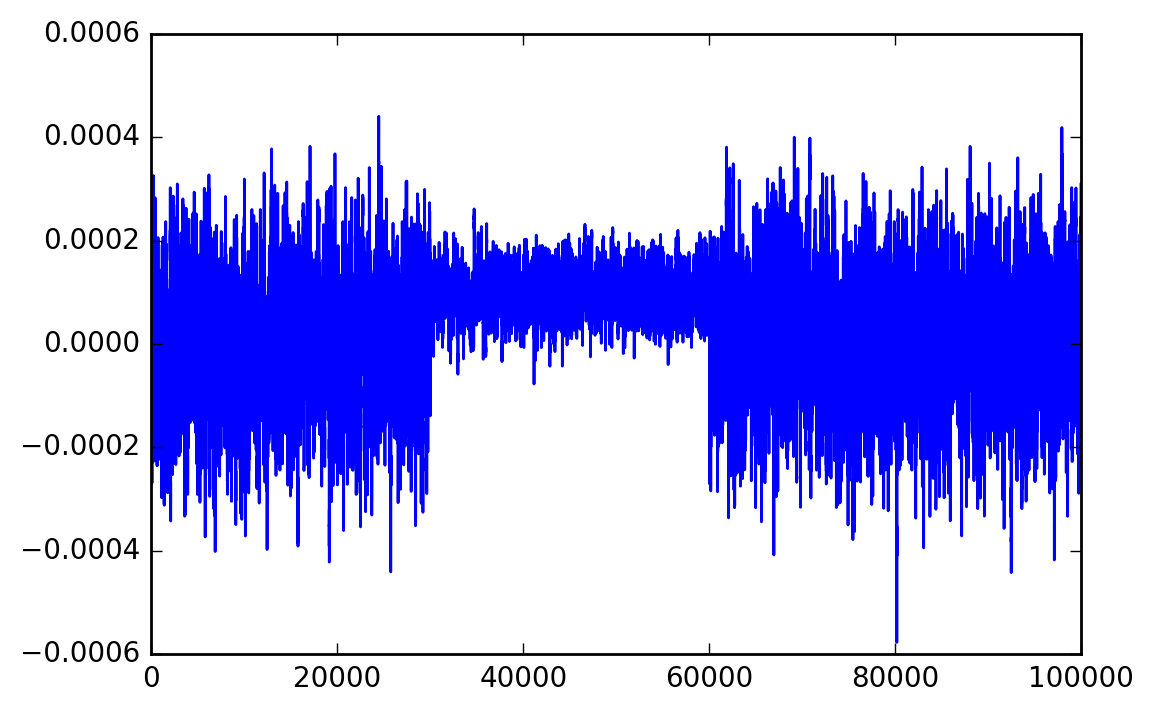

In [4]:
myStepSig = myDampSig
myStepSig[30000:60000] = myDampSig[30000:60000]*0.35 + 1e-4

plt.figure()
plt.plot(myStepSig)
plt.show()

In [5]:
#Neural Network sub-functions

def sigmoid(z):
    #Returns the logistic of the value z
    mySig = 1 / (1+np.exp(-z))
    return mySig

def sigmoidGradient(z):
    #return the gradient of a sigmoid function at value z
    mySigGrad = sigmoid(z)*(1-sigmoid(z))
    return mySigGrad

def hidToVis(rbmW,hidStates):
    visProb = np.dot(rbmW.T,hidStates)
    visProb = sigmoid(visProb)
    return visProb

def visToHid(rbmW,visStates):
    hidProb = np.dot(rbmW,visStates)
    hidProb = sigmoid(hidProb)
    return hidProb

def initRBMW(hLayer,vLayer,mySeed=1.0):
    np.random.seed(mySeed)
    rbmW = np.random.random((hLayer,vLayer))
    return rbmW

def sampPRand(myInput,seed=1):
    #Compare input to pseudo-random variables
    myTest = myInput > np.random.random(np.shape(myInput))
    return myTest * 1

def myGoodness(rbmW,hidStates,visStates):
    #m = np.shape(visStates)[1]
    E = - np.mean(np.dot(np.dot(rbmW, visStates).T, hidStates));
    G = -(E); 
    return G
    
def myGoodnessGrad(hidStates,visStates):
    m = np.shape(visStates)[1];
    myGG = np.dot(visStates,hidStates.T)
    myGG = myGG.T/ m;
    return myGG

def trainRBMLayers(a0,hiddenLayers,lR,myIter):
    #Train an RBM layer based on visible input layer a0
    #a0 - visible units
    #hiddenLayers - number of hidden layers
    #lR - learning rate
    #myIter - number of iterations to train
    myTest = a0
    J = []
    rbmW = initRBMW(hiddenLayers,np.shape(myTest)[0],1)
    for j in range(myIter):
        myTest = sampPRand(a0)
        myHid = visToHid(rbmW,myTest)
        myHid0 = myHid
        #print(myHid)
        myHid = sampPRand(myHid)
        #print(myHid[:,10])
        myDream = hidToVis(rbmW,myHid)
        E = (a0-myDream)
        J.append(np.mean(np.abs(E)))
        myDream = sampPRand(myDream)
        myReconProb = visToHid(rbmW,myDream)
        myRecon = sampPRand(myReconProb)
        myPos = myGoodnessGrad(myHid,myTest)

        myNeg = myGoodnessGrad(myRecon,myDream)
        rbmW = rbmW + lR* (myPos-myNeg)
        if ( j % (myIter/10) == 0):
            G = myGoodness(rbmW,myHid,myTest)
            print("Iteration " + str(j)+" Error = " + str(np.mean(np.abs(E))))
            print("Goodness = " + str(G))
            
    plt.plot(J)
    plt.show()
    print("Finished with RBM training of size " + str(np.shape(rbmW.T)))
    return rbmW.T

#forward propagation 
def forProp(myInputs,myWeights):
    #print(np.shape(myInputs))
    #print(np.shape(myWeights[0]))
    zn = [] #np.dot(myInputs,myWeights[0])
    an = [] #sigmoid(zn)
    if(0):
        for n in range(len(myWeights)):
            zn.append(np.zeros((      np.shape(myWeights[n][1])[0],np.shape(a0)[0])))
            an.append(np.zeros((      np.shape(myWeights[n][1])[0],np.shape(a0)[0])))
        
    
    #zn[0,:] = np.array([np.dot(myInputs,myWeights[0])])
    #an[0,:] = sigmoid(zn[0,:])
    if(0):
        zn[0] = np.dot(myInputs.T,myWeights[0])
        an[0] = sigmoid(zn[0])
    zn.append(np.squeeze(np.dot(myInputs.T,myWeights[0])))
    #print(np.shape(zn))
    an.append(sigmoid(zn[0]))
    #print(np.shape(zn[0]))
    for n in range(1,len(myWeights)):
        #print(np.shape(an))
        #print(np.shape(myWeights[n]))
        if(0):
            print(n)
            zn[n] = np.dot(an[n-1],myWeights[n])
            an[n] = sigmoid(zn[n])
        zn.append(np.dot(an[n-1],myWeights[n]))
        an.append(sigmoid(zn[n]))
        #print(np.shape(an[n]))
        #print(np.shape(an))
    #print(np.shape(an[0]))
    #print(np.shape(np.squeeze(an)))
    return an,zn



#back propagation function

def backProp(myInputs,myCrossInputs,myTarget,myWeights,myIter=10,lR=1e-5,myLambda=0,myMom=1e-5,dropout=False):
    #init momentum
    momSpeed = []
    #init weight penalties
    wPen = []
    #init gradients
    dGrad = []
    Delta = []
    for n in range(len(myWeights)): #-1,-1,-1):
        wPen.append(0*myWeights[n])
        dGrad.append(0*myWeights[n])
        momSpeed.append(0*myWeights[n])
        Delta.append(0*myWeights[n])
        #print(np.shape(wPen[n]))
        #print(np.shape(dGrad[n]))
        #print(np.shape(momSpeed[n]))
    m = m = np.shape(myInputs)[1]
   
    myFreq = int(myIter/10)
  
    print("Begin Training . . . ")
    for i in range(myIter):
        #Run forward propagation.
        myOutput, myZ = forProp(myInputs,myWeights)
        #print(np.shape(myOutput))
        #print(np.shape(myZ[0]))
        #use squared error as objective function
        E = (myTarget.T-myOutput[len(myOutput)-1])
        d = []
        #print(np.shape(E.T))
        d.append(E.T)
        #print(np.shape(d[0]))
        #d.append(E.T)
       

        if(i%myFreq == 0):
            print("Iteration " + str(i) + " Mean error = "+str(np.mean(np.abs(E))))


        for n in range(len(myWeights)-1,-1,-1):
            #
            d.append(np.dot(myWeights[n],d[len(d)-1]) * sigmoidGradient(myZ[n-1].T))
           

        for n in (range(len(myWeights)-1,-1,-1)):
           
            for i in range(m-1):
                #
                Delta[n] =Delta[n] + np.dot(np.array([myOutput[n-1][i,:]]).T,np.array([d[len(d)-(n+2)][:,i]]))
               
        
        for n in (range(len(myWeights)-1,-1,-1)):
            wPen[n] = myLambda * myWeights[n]

        for n in (range(len(myWeights)-1,-1,-1)):
            #print(n)
            dGrad[n] = Delta[n]/m +wPen[n]
            momSpeed[n] = myMom*momSpeed[n] + dGrad[n]
            
            myWeights[n] = myWeights[n] + momSpeed[n] * lR
            #print(np.mean(Theta3))
        #print("Training Finished, avg error = "+str(np.mean(np.abs(E))))
        #print(E)
    return myWeights

In [6]:
myWind = 512
myStride = 96
x = myStepSig
myLength = len(myStepSig)
t = time.time()
#Fill out the vectors for training, (a0), cross validation (a0Cross), and validation (a0Val) data
#vectors are dimensions <number of examples> by <filter window size>
y = (np.array([x[0:myWind]]))

for c in range(int(myLength*0.0)+myStride,int(myLength*0.8)-myStride,myStride):
    #yCross = np.append(yCross,np.fft.fft(np.array([x[c:myWind+c]])),0)
    if (myWind+c) < len(x):
        y = np.append(y,(np.array([x[c:myWind+c]])),0)
    #y = np.append(y,y,0)
    #print(c)
    #print(np.shape(np.array([x[c:myWind+c]])))

a0 = y
#cross validation data
#yCross = np.fft.fft
yCross = (np.array([x[int(myLength*0.8):int(myLength*0.8)+myWind]]))
for c in range(int(myLength*0.8)+myStride,int(myLength*0.9)-myStride,myStride):
    #yCross = np.append(yCross,np.fft.fft(np.array([x[c:myWind+c]])),0)
    if (myWind+c) < len(x):
        yCross = np.append(yCross,(np.array([x[c:myWind+c]])),0)
    #y = np.append(y,y,0)
    #print(c)

#cross validation data
myStride = 1000
#yVal = np.fft.fft
yVal = (np.array([x[int(myLength*0.9):int(myLength*0.9)+myWind]]))
for c in range(int(myLength*0.9)+myWind,int(myLength)-myWind-myStride,myStride):
    #yVal = np.append(yVal,np.fft.fft(np.array([x[c:myWind+c]])),0)
    if (myWind+c) < len(x):
        yVal = np.append(yVal,(np.array([x[c:myWind+c]])),0)
    #y = np.append(y,y,0)
    #print(c)
    #print(np.shape(np.array([x[c:myWind+c]])))


print(np.shape(y))
y=y.T
a0 = y
print(np.shape(yCross))
yCross = yCross.T
a0Cross = yCross
print(np.shape(yVal))
yVal = yVal.T
a0Val = yVal

elapsed = time.time()-t
print(elapsed)

(833, 512)
(104, 512)
(9, 512)
0.2271595001220703


Iteration 0 Error = 0.999964395646
Goodness = 2.47875282216
Iteration 400 Error = 0.999630944257
Goodness = 0.330853228573
Iteration 800 Error = 0.137350510716
Goodness = -0.112727772691
Iteration 1200 Error = 0.0582462288458
Goodness = -0.166199110942
Iteration 1600 Error = 0.033949099644
Goodness = -0.187685676398
Iteration 2000 Error = 0.0231398816302
Goodness = -0.174376956352
Iteration 2400 Error = 0.0166707782395
Goodness = -0.194883764435
Iteration 2800 Error = 0.013273584836
Goodness = -0.203759324441
Iteration 3200 Error = 0.0107245077087
Goodness = -0.170753144529
Iteration 3600 Error = 0.00898017717119
Goodness = -0.303413896355


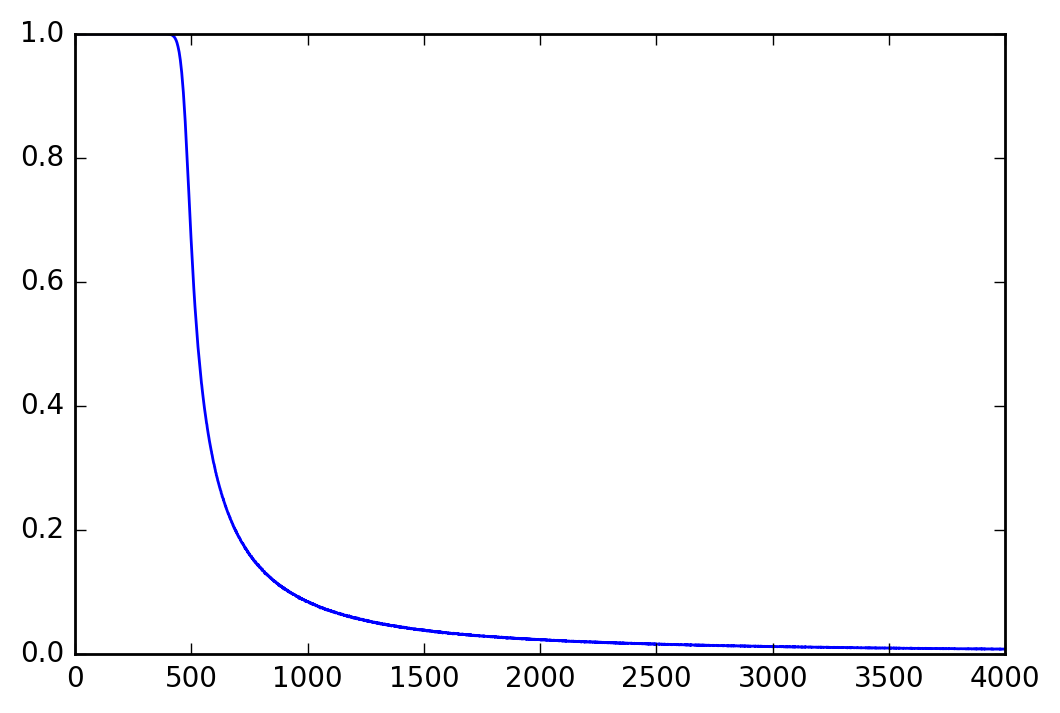

Finished with RBM training of size (512, 256)
Iteration 0 Error = 1.05633864755
Goodness = 1568.43167618
Iteration 400 Error = 1.05632718615
Goodness = 392.576454032
Iteration 800 Error = 0.425581694519
Goodness = -27.3289683262
Iteration 1200 Error = 0.370341182985
Goodness = -38.4746983583
Iteration 1600 Error = 0.352570499766
Goodness = -42.1932667307
Iteration 2000 Error = 0.342562420449
Goodness = -44.5301410703
Iteration 2400 Error = 0.339949516579
Goodness = -44.5280199855
Iteration 2800 Error = 0.334303446096
Goodness = -45.582787413
Iteration 3200 Error = 0.331789154231
Goodness = -46.5167327321
Iteration 3600 Error = 0.331405446681
Goodness = -46.1853493072


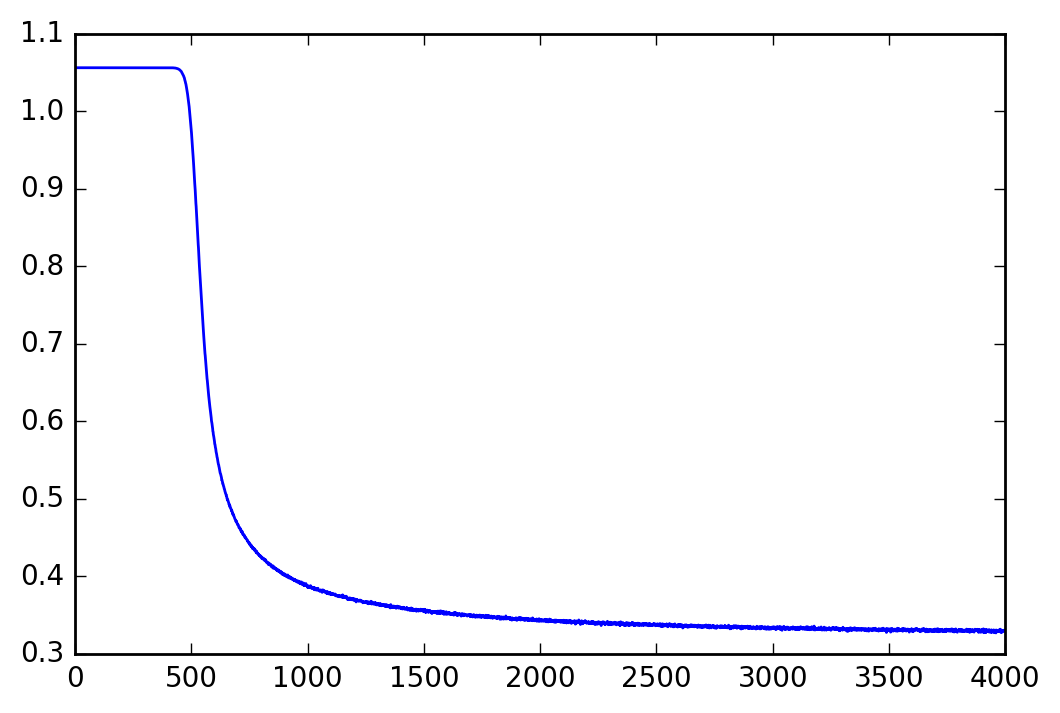

Finished with RBM training of size (256, 128)
Iteration 0 Error = 1.05960170298
Goodness = 379.189269748
Iteration 400 Error = 1.05213985807
Goodness = 81.5903415592
Iteration 800 Error = 0.458836094534
Goodness = -7.82868088407
Iteration 1200 Error = 0.389680116689
Goodness = -13.4695049416
Iteration 1600 Error = 0.364412614516
Goodness = -15.3365411942
Iteration 2000 Error = 0.354644907282
Goodness = -16.9349967812
Iteration 2400 Error = 0.344920493457
Goodness = -17.5220695756
Iteration 2800 Error = 0.339863720771
Goodness = -17.8853834375
Iteration 3200 Error = 0.337415331143
Goodness = -18.3316842032
Iteration 3600 Error = 0.336883351166
Goodness = -18.4974235969


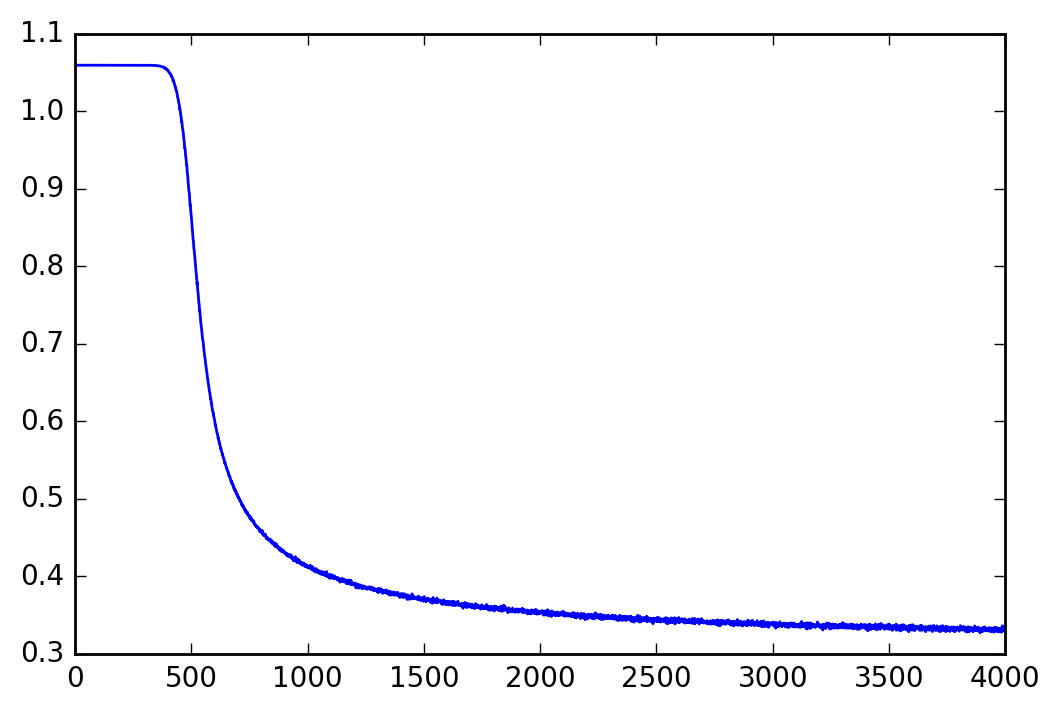

Finished with RBM training of size (128, 64)
Iteration 0 Error = 1.08182237821
Goodness = 77.5333893754
Iteration 400 Error = 0.99639740947
Goodness = 14.5462357185
Iteration 800 Error = 0.520563227837
Goodness = -1.68191219145
Iteration 1200 Error = 0.431027756153
Goodness = -4.13182303411
Iteration 1600 Error = 0.406453450274
Goodness = -4.92851224572
Iteration 2000 Error = 0.383800014291
Goodness = -5.94116738722
Iteration 2400 Error = 0.372534008288
Goodness = -6.0460837527
Iteration 2800 Error = 0.363562273459
Goodness = -6.56293623715
Iteration 3200 Error = 0.35150422498
Goodness = -6.63948575624
Iteration 3600 Error = 0.344510202528
Goodness = -7.44240486469


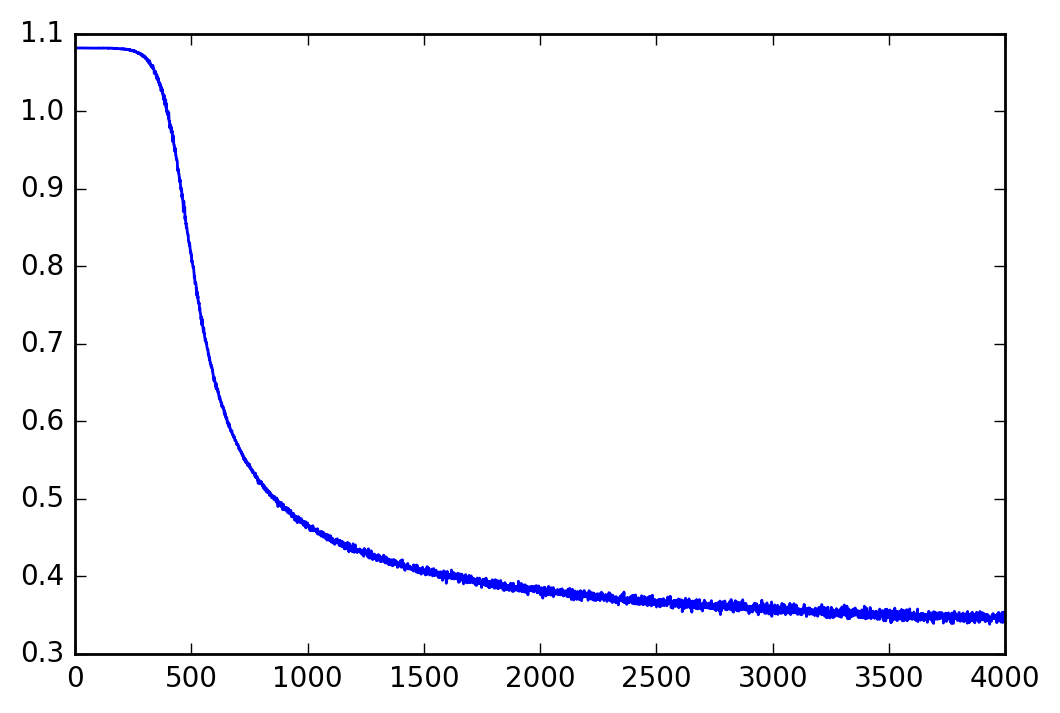

Finished with RBM training of size (64, 32)
Iteration 0 Error = 1.11589104545
Goodness = 12.5062675113
Iteration 400 Error = 0.913057386548
Goodness = 3.47381303347
Iteration 800 Error = 0.609394766646
Goodness = -0.0689904548398
Iteration 1200 Error = 0.5084100777
Goodness = -1.0505512083
Iteration 1600 Error = 0.474682327676
Goodness = -1.53522992579
Iteration 2000 Error = 0.437556751431
Goodness = -1.57045614925
Iteration 2400 Error = 0.430137419175
Goodness = -1.75317258636
Iteration 2800 Error = 0.427828195341
Goodness = -1.81387893929
Iteration 3200 Error = 0.40542586113
Goodness = -2.34883396504
Iteration 3600 Error = 0.397420234999
Goodness = -2.38199369422


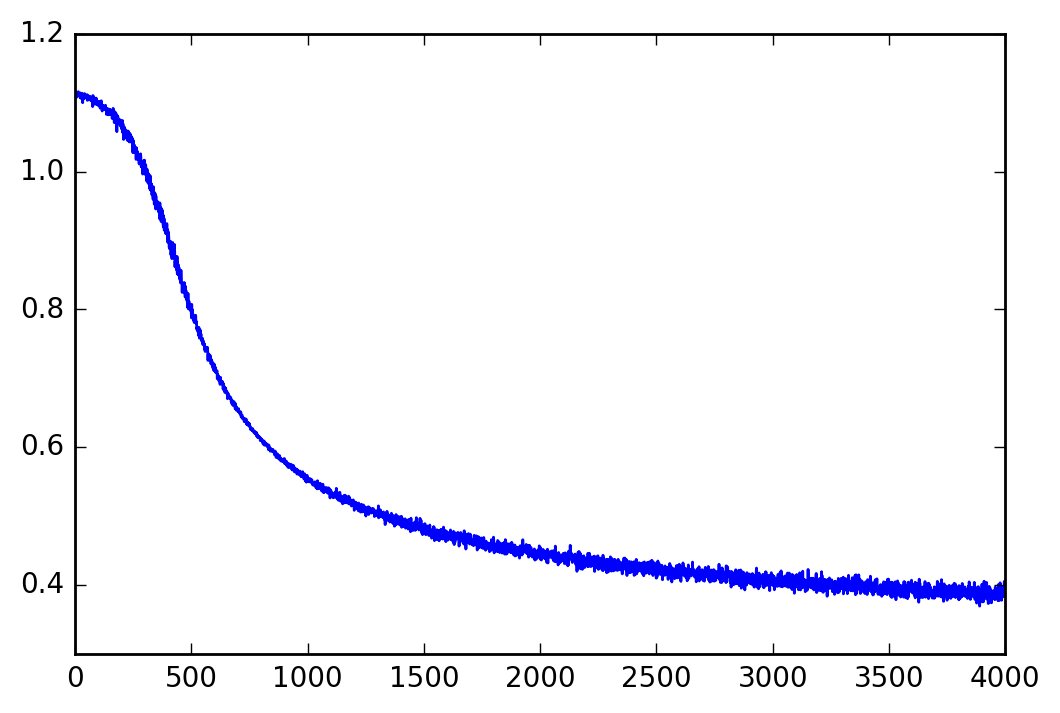

Finished with RBM training of size (32, 16)
Iteration 0 Error = 1.04718647538
Goodness = 1.56324897033
Iteration 400 Error = 0.881246616076
Goodness = 0.437511214398
Iteration 800 Error = 0.719279311608
Goodness = 0.121387809094
Iteration 1200 Error = 0.63274025733
Goodness = -0.0877948954517
Iteration 1600 Error = 0.594222716603
Goodness = -0.254647889323
Iteration 2000 Error = 0.548980598465
Goodness = -0.365438173983
Iteration 2400 Error = 0.531993458332
Goodness = -0.4704154031
Iteration 2800 Error = 0.501216740221
Goodness = -0.484775266346
Iteration 3200 Error = 0.488933162203
Goodness = -0.451620677396
Iteration 3600 Error = 0.469914520964
Goodness = -0.713163104371


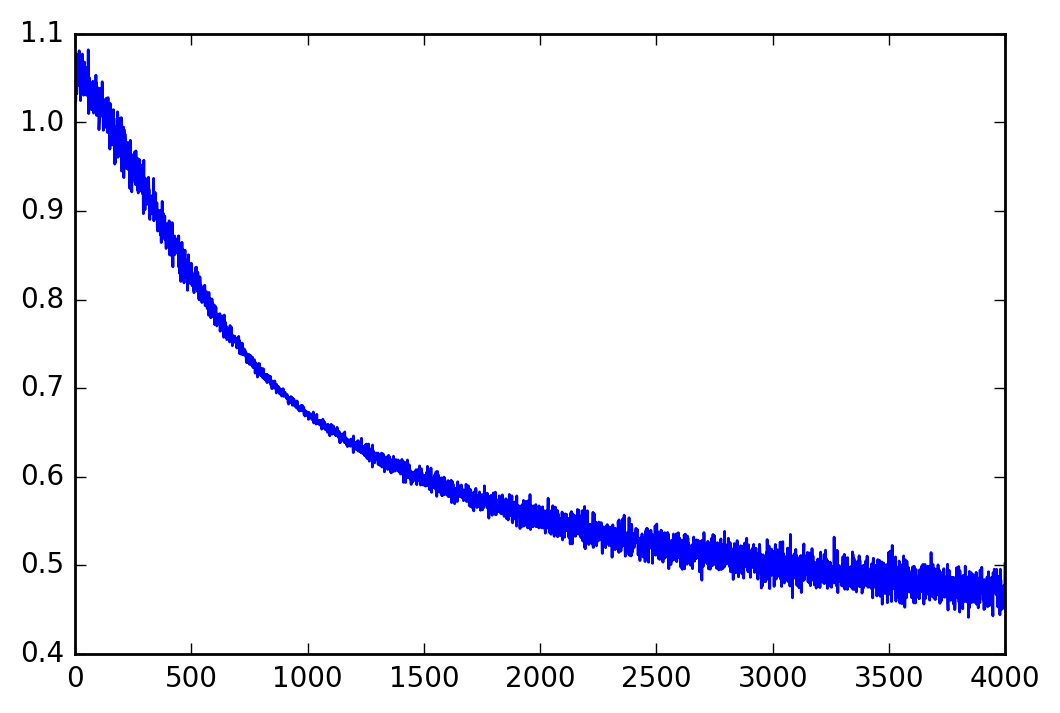

Finished with RBM training of size (16, 8)
Iteration 0 Error = 0.941115867029
Goodness = 0.0302060817379
Iteration 400 Error = 0.870158042152
Goodness = 0.0076700927535
Iteration 800 Error = 0.798193636958
Goodness = 0.0294952820487
Iteration 1200 Error = 0.751568627284
Goodness = -0.0443269074095
Iteration 1600 Error = 0.722306510098
Goodness = 0.0110790419474
Iteration 2000 Error = 0.681635718404
Goodness = -0.0427592388032
Iteration 2400 Error = 0.666298457722
Goodness = 0.0
Iteration 2800 Error = 0.655764342075
Goodness = 0.0
Iteration 3200 Error = 0.662094951202
Goodness = -0.0412186892526
Iteration 3600 Error = 0.604574721814
Goodness = -0.0398865148136


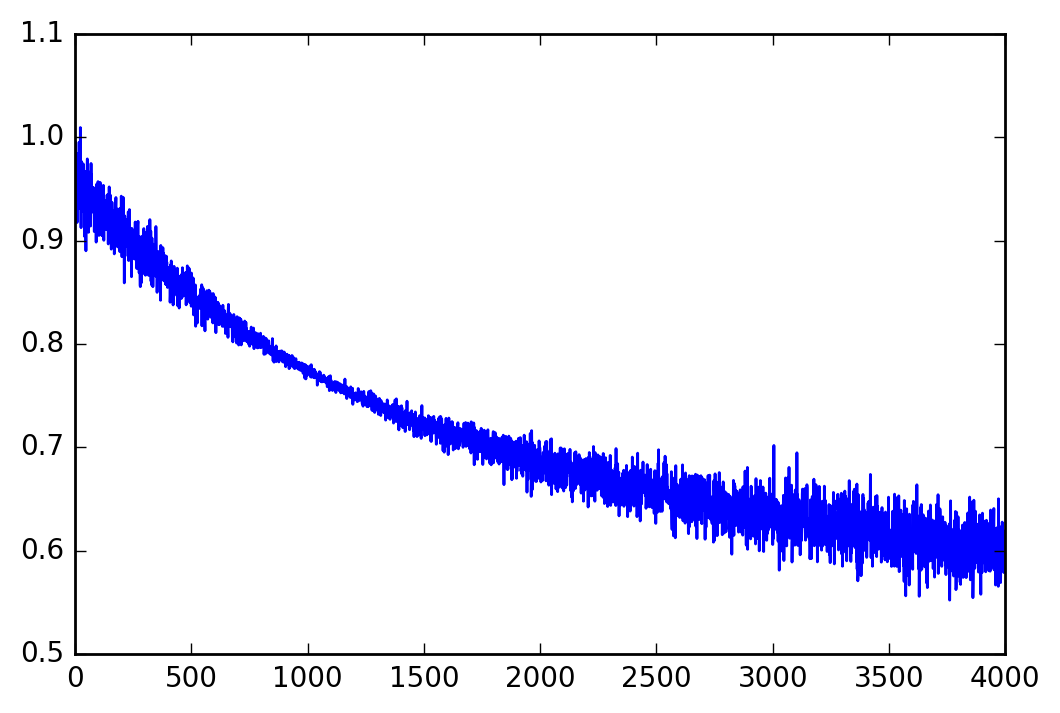

Finished with RBM training of size (8, 4)
Time to train RBMs 1295.4461402893066
4245.5964431762695


In [50]:
#Train the r. Boltzmann machines
t0 = time.time()
trainIt = 4000
rbm256 = trainRBMLayers(a0,256,1e-3,trainIt)
rbm128 = trainRBMLayers(rbm256.T,128,1e-3,trainIt)
rbm64 = trainRBMLayers(rbm128.T,64,1e-3,trainIt)
rbm32 = trainRBMLayers(rbm64.T,32,1e-3,trainIt)
rbm16 = trainRBMLayers(rbm32.T,16,1e-3,trainIt)
rbm8 = trainRBMLayers(rbm16.T,8,1e-3,trainIt)
rbm4 = trainRBMLayers(rbm8.T,4,1e-3,trainIt)
elapsed = time.time() - t0
print("Time to train RBMs " + str(elapsed))
elapsed = time.time()-t
print(elapsed)

In [101]:
myWeights = []
myWeights.append(rbm256)
#myWeights.append(rbm128)
#myWeights.append(rbm64)
#myWeights.append(rbm32)
#myWeights.append(rbm16)
#myWeights.append(rbm8)
#myWeights.append(rbm4)
#myWeights.append(rbm4.T)
#myWeights.append(rbm8.T)
#myWeights.append(rbm16.T)
#myWeights.append(rbm32.T)
#myWeights.append(rbm64.T)
#myWeights.append(rbm128.T)
myWeights.append(rbm256.T)

(512,)
(100000,)
(98816,)


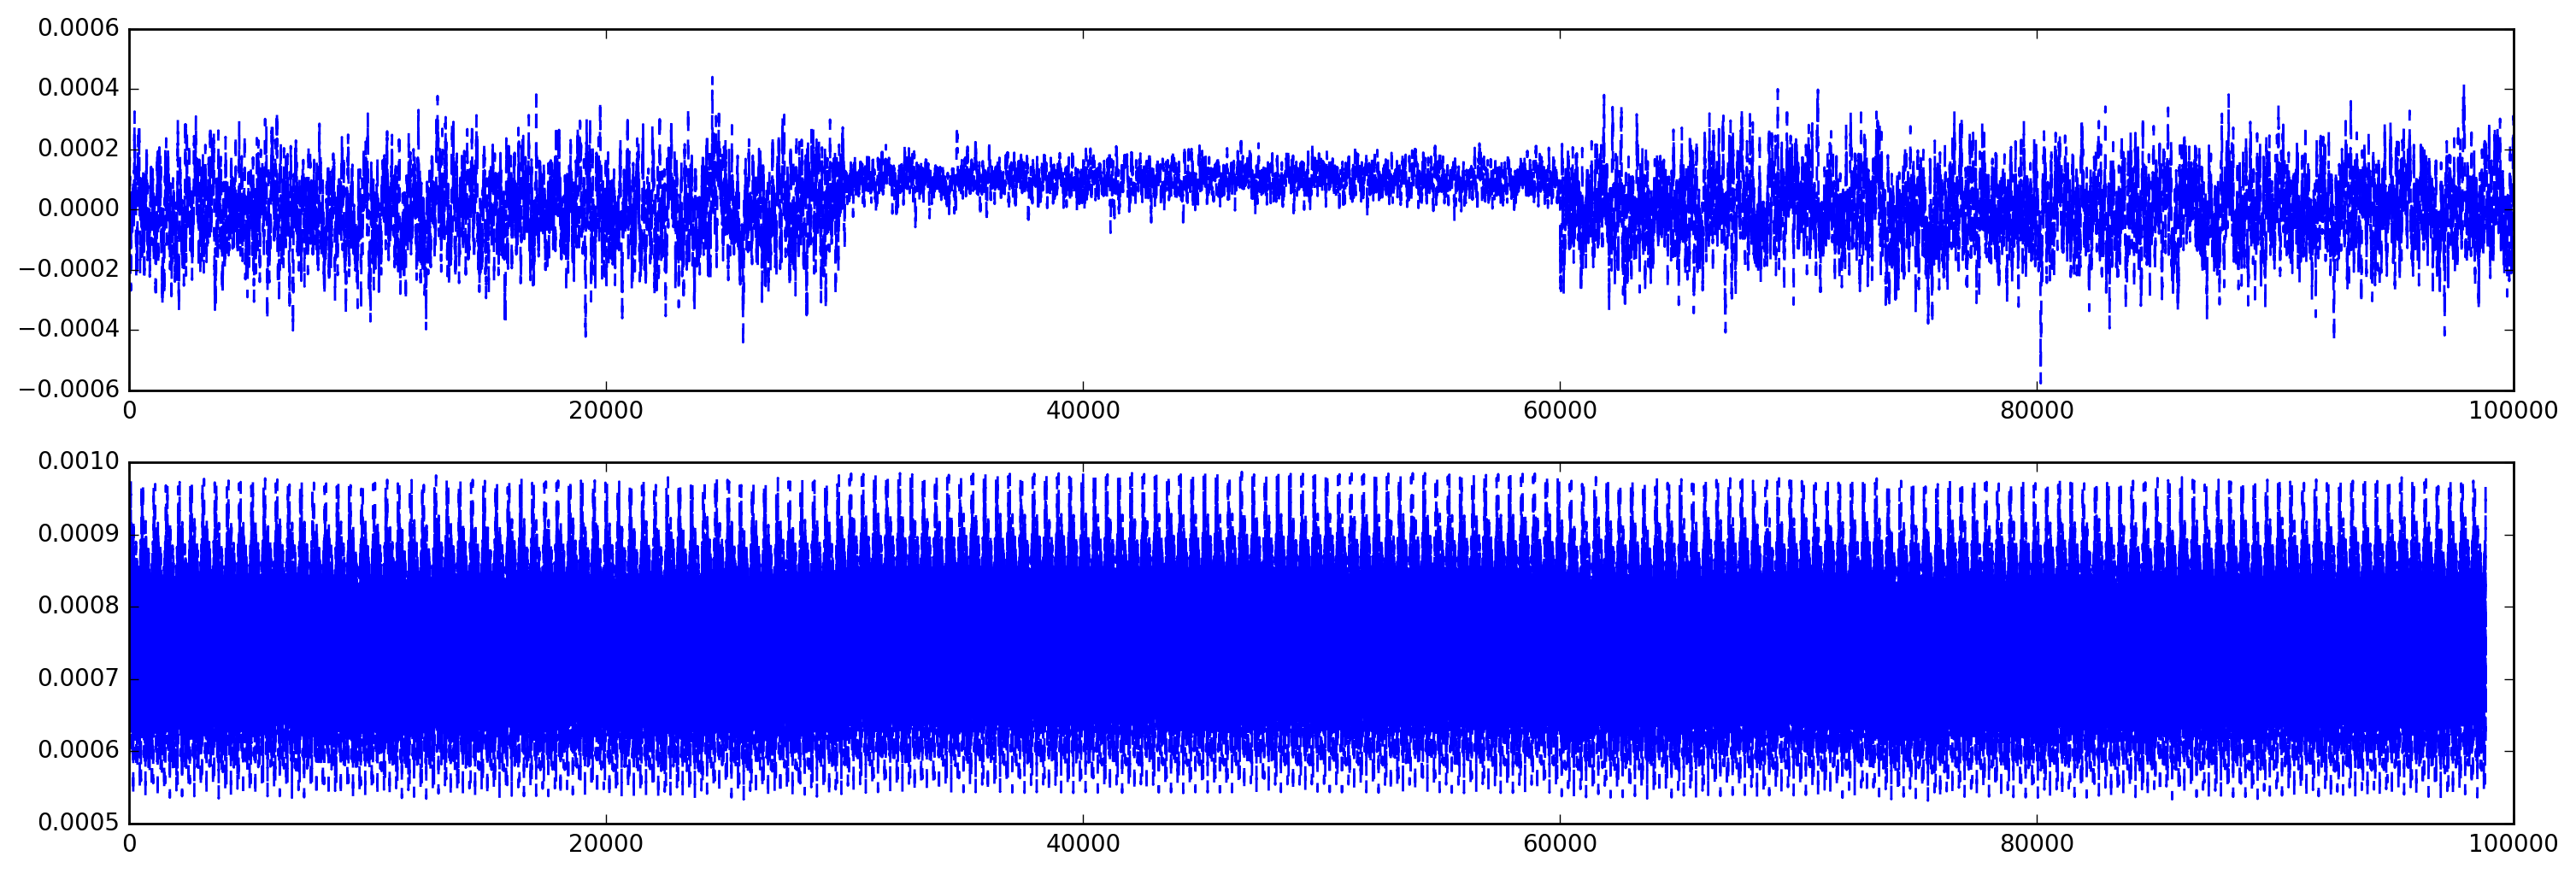

In [86]:
myNewWeights = myWeights#1024x256
if(1):
    k=0
    a0Rec, zn =forProp(np.array([x[k:k+myWind]]).T,myNewWeights)
    yOut1 = np.array(a0Rec[1])
    print(np.shape(yOut1))
    for k in range(myWind,myLength-myWind-myStride,myWind):#myLength-myWind,myWind):
        #print(k)
        a0Rec, zn =forProp(np.array([x[k:k+myWind]]).T,myNewWeights)
        
        #print(np.shape(yOut1))
        #print(np.shape(a0Rec[1]))
        yOut1 = np.append(yOut1,a0Rec[1],0)
print(np.shape(x))
print(np.shape(yOut1))
myFig, myAx = plt.subplots(2,1,figsize=(18,6))
myAx[0].plot(x[0:287000],'--')
myAx[1].plot(yOut1[0:287000],'--')
plt.show()

In [107]:
t = time.time()
myIt = 8000
#(myInputs,myCrossInputs,myTarget,myWeights,myIter=10,lR=1e-5,myLambda=0,myMom=1e-5,dropout=False):
myNewWeights1 = backProp(a0,a0Cross,a0,myWeights,myIt,2e-7)#,1e-10,1e-3)
elapsed = time.time()-t
print("time to train for" + str(myIt) + " iterations = "+str(elapsed) + " seconds")

Begin Training . . . 
Iteration 0 Mean error = 0.000708384113562
Iteration 800 Mean error = 0.000706211492732
Iteration 1600 Mean error = 0.000699750641306
Iteration 2400 Mean error = 0.000689153601417
Iteration 3200 Mean error = 0.00067466523198
Iteration 4000 Mean error = 0.000656611228767
Iteration 4800 Mean error = 0.000635382788993
Iteration 5600 Mean error = 0.000611419132868
Iteration 6400 Mean error = 0.000585189168279
Iteration 7200 Mean error = 0.000557173521392
time to train for8000 iterations = 3883.20476603508 seconds


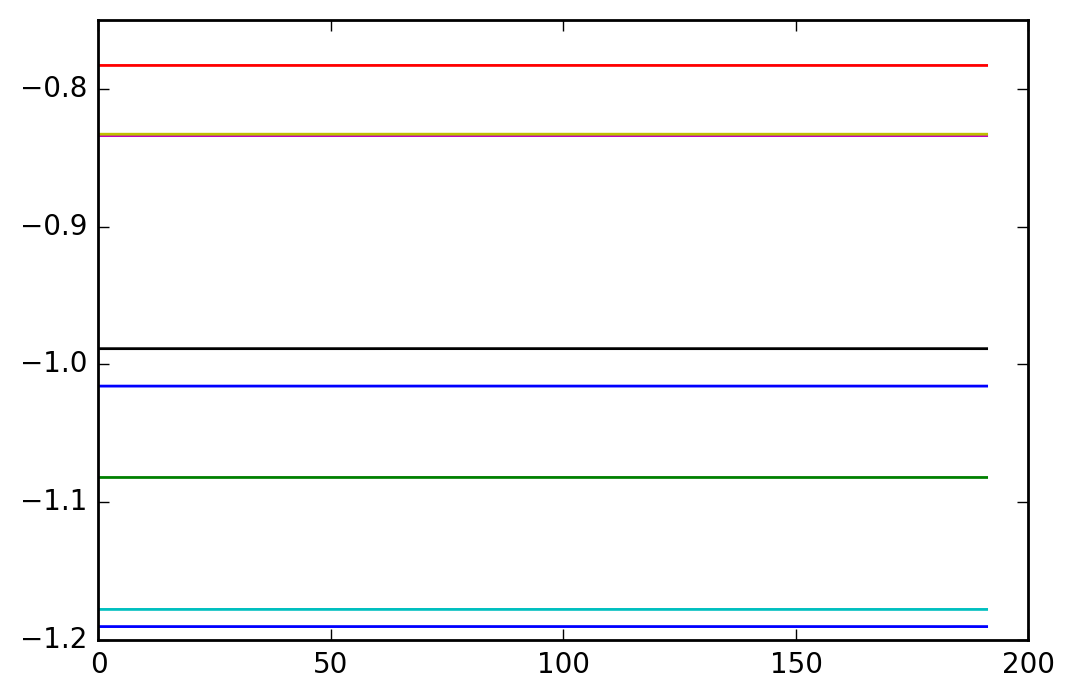

In [77]:
#print(np.shape(np.array([Z[:,0]])))
plt.figure()
#for c in range(32):
    #print((Z[c][0]))
    
plt.plot(Z[:])
plt.show()

/home/main/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/main/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/main/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(100000,)
98560
98944


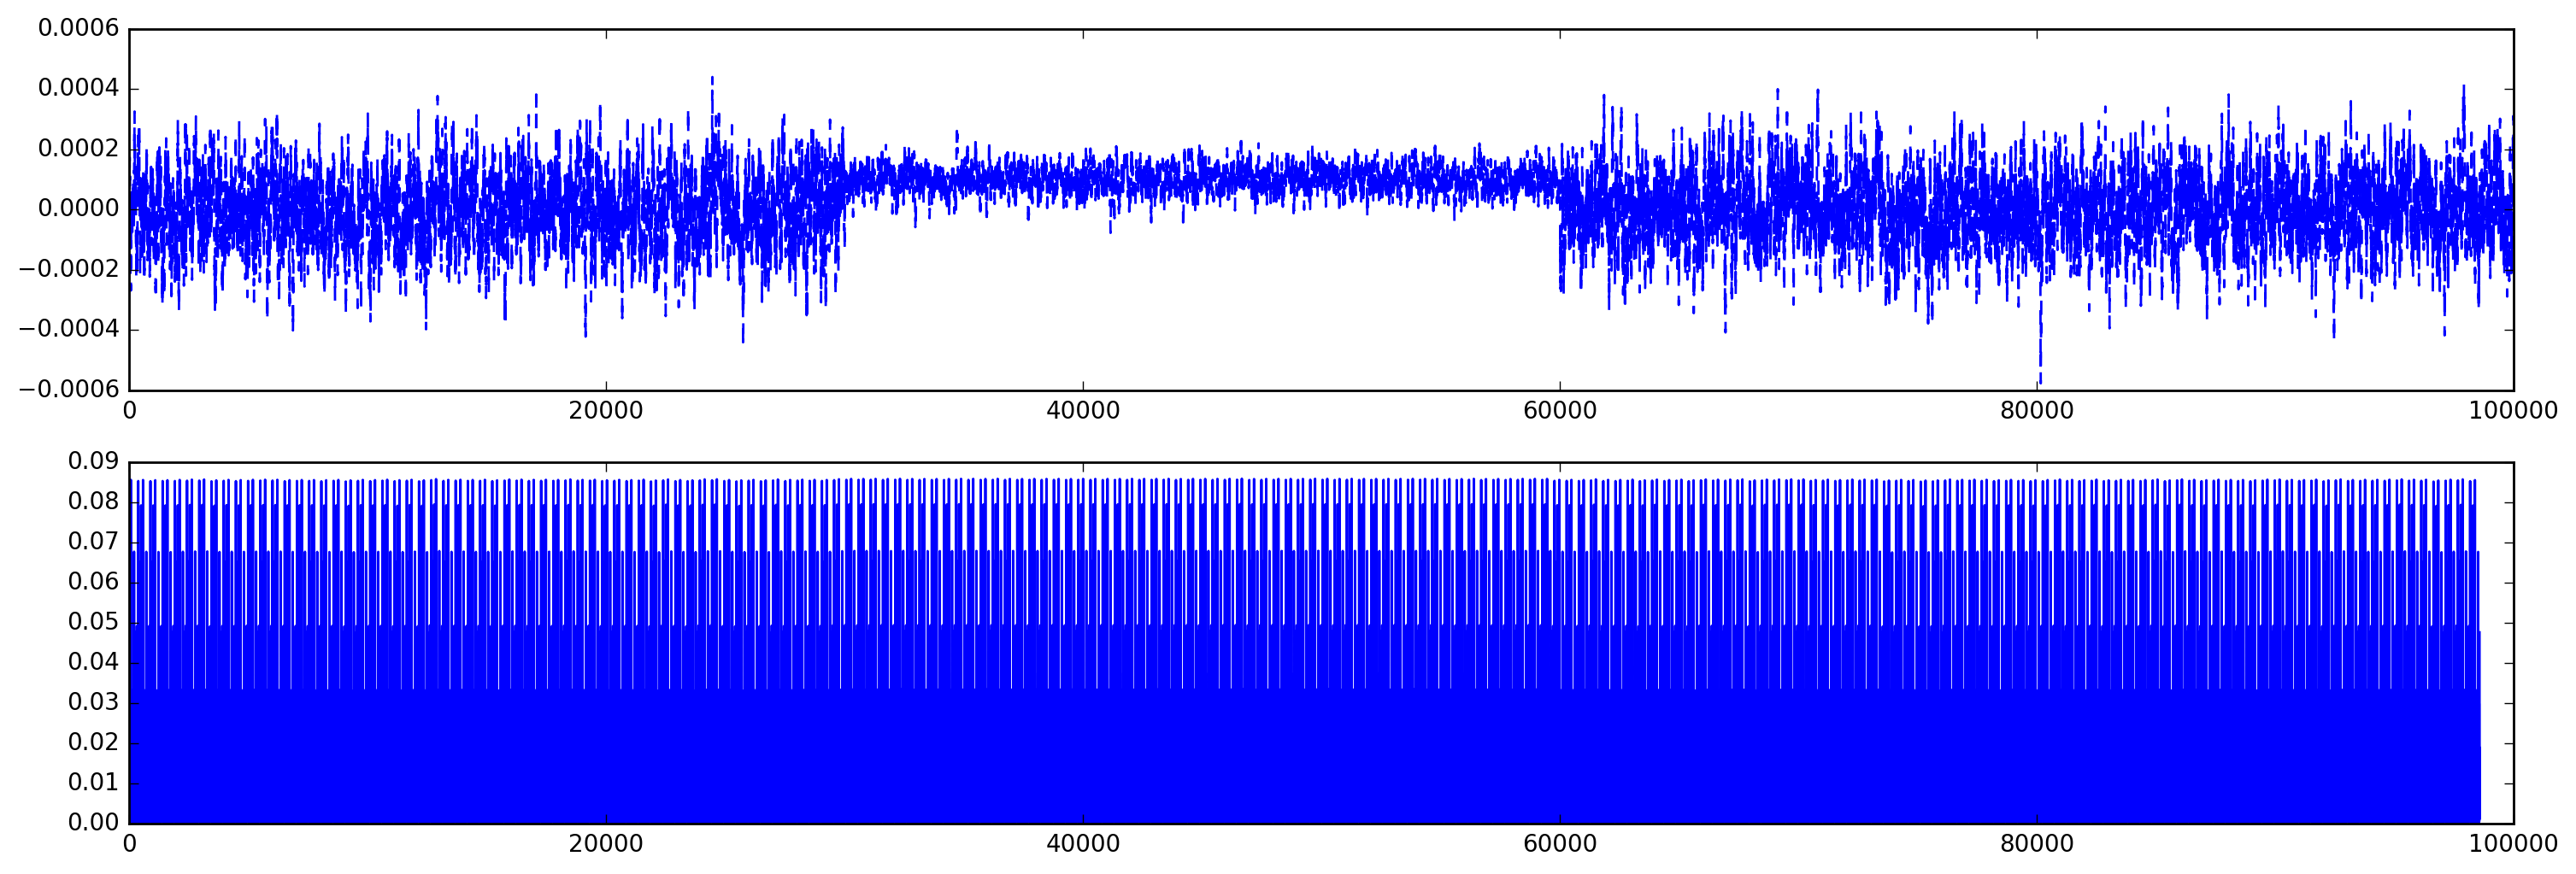

In [104]:
myNewWeights = myWeightsCopy#1024x256
if(1):
    k=0
    a0Rec, zn =forProp(np.array([x[k:k+myWind]]).T,myNewWeights)
    yOut1 = np.array(a0Rec[1])
    #print(np.shape(yOut1))
    for k in range(myWind,myLength-myWind-myStride,myWind):#myLength-myWind,myWind):
        #print(k)
        a0Rec, zn =forProp(np.array([x[k:k+myWind]]).T,myNewWeights)
        
        #print(np.shape(yOut1))
        #print(np.shape(a0Rec[1]))
        yOut1 = np.append(yOut1,a0Rec[1],0)
    k=myWind/2
    a0Rec, zn =forProp(np.array([x[k:k+myWind]]).T,myNewWeights)
    yOut2 = np.array(a0Rec[1])
    #print(np.shape(yOut1))
    for k in range(myWind,myLength-myWind-myStride,myWind):#myLength-myWind,myWind):
        #print(k)
        a0Rec, zn =forProp(np.array([x[k:k+myWind]]).T,myNewWeights)
        
        #print(np.shape(yOut1))
        #print(np.shape(a0Rec[1]))
        yOut2 = np.append(yOut1,a0Rec[1],0)
print(np.shape(x))
yOut1 = yOut1[myWind/2:len(yOut1)]
yOut2 = yOut2[0:len(yOut2)-myWind/2-128]
print(len(yOut1))
print(len(yOut2))
myFig, myAx = plt.subplots(2,1,figsize=(18,6))
myAx[0].plot(x[0:287000],'--')
myAx[1].plot((yOut1))
#myAx[1].plot(Z[])
plt.show()

In [120]:
24576-24448

128

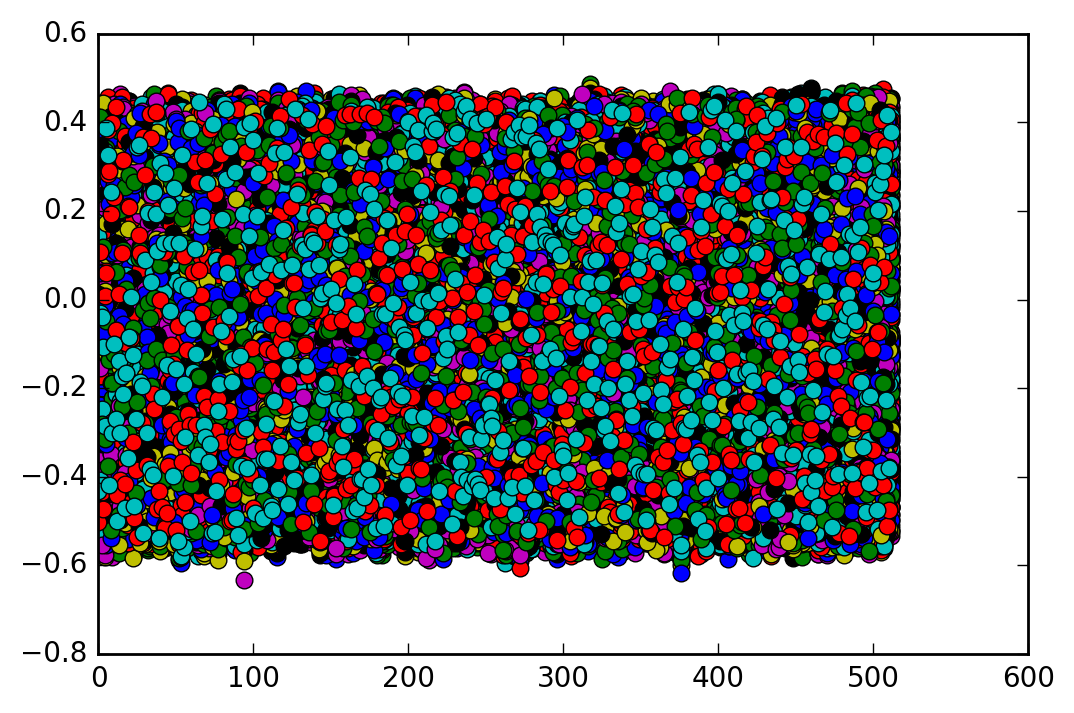

(512, 256)


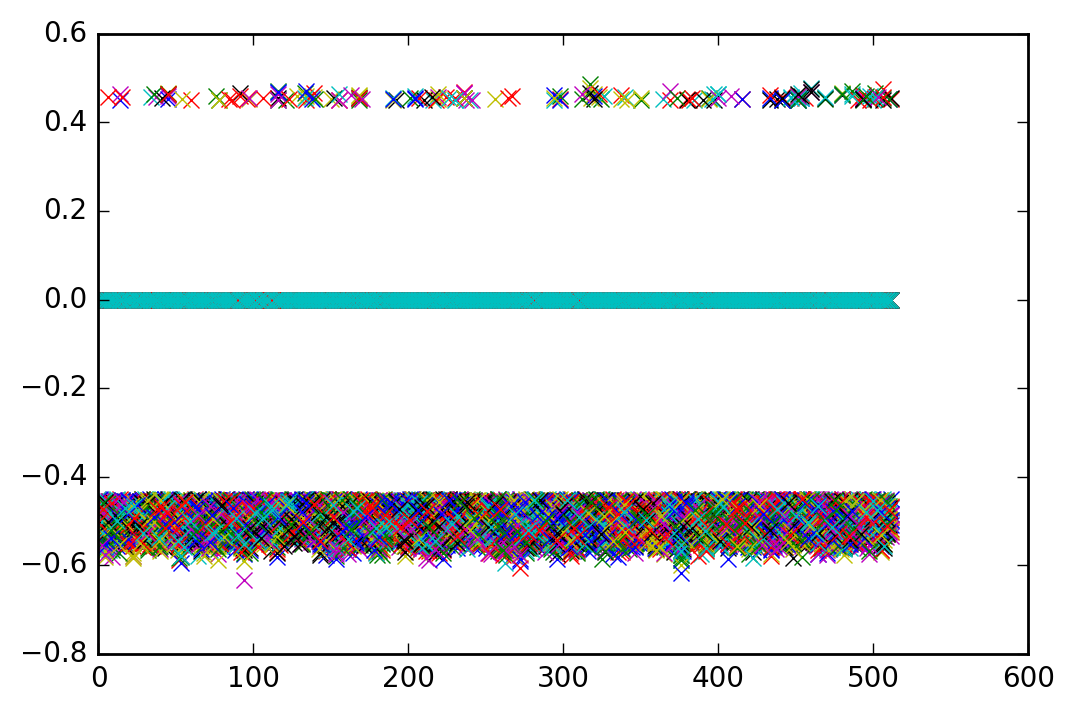

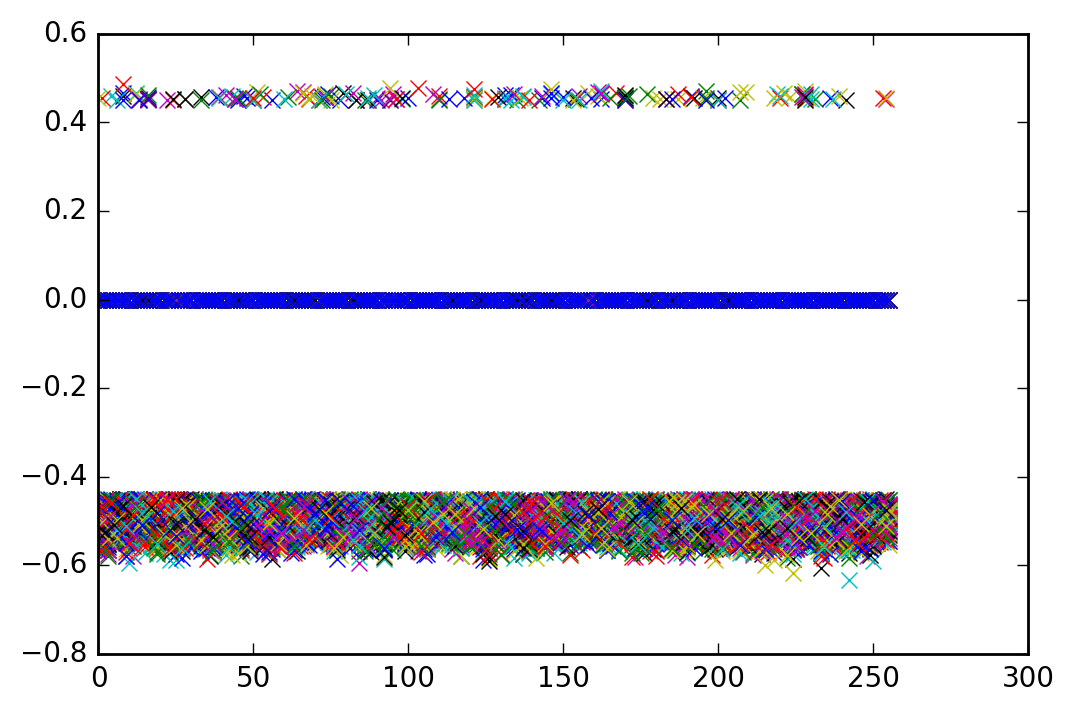

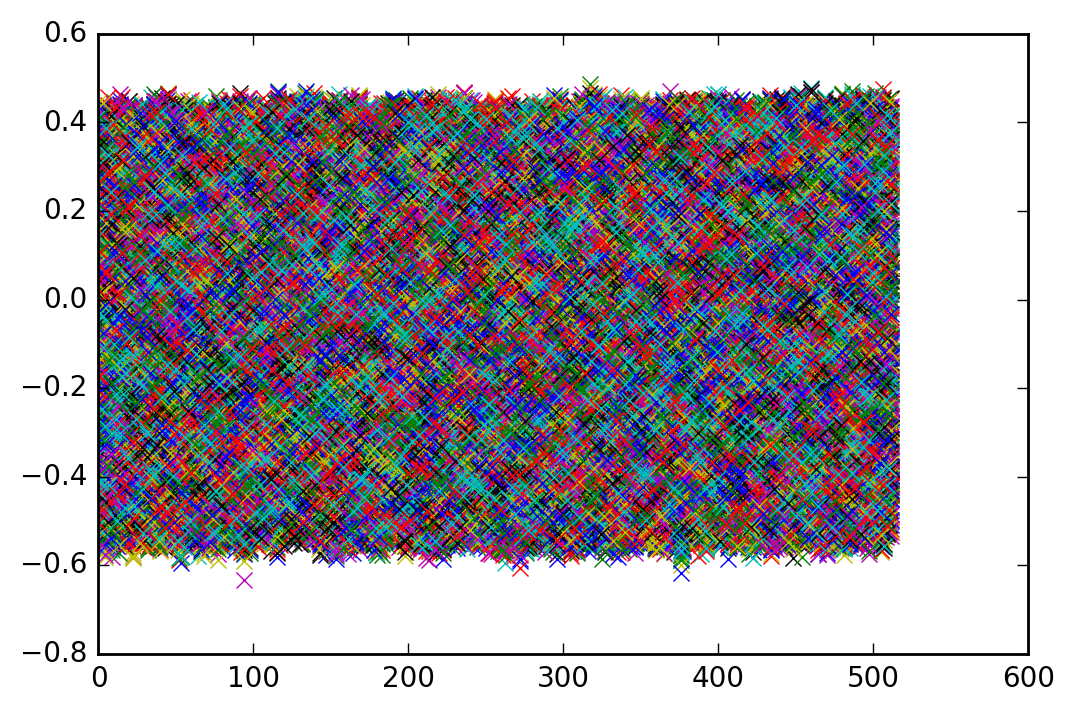

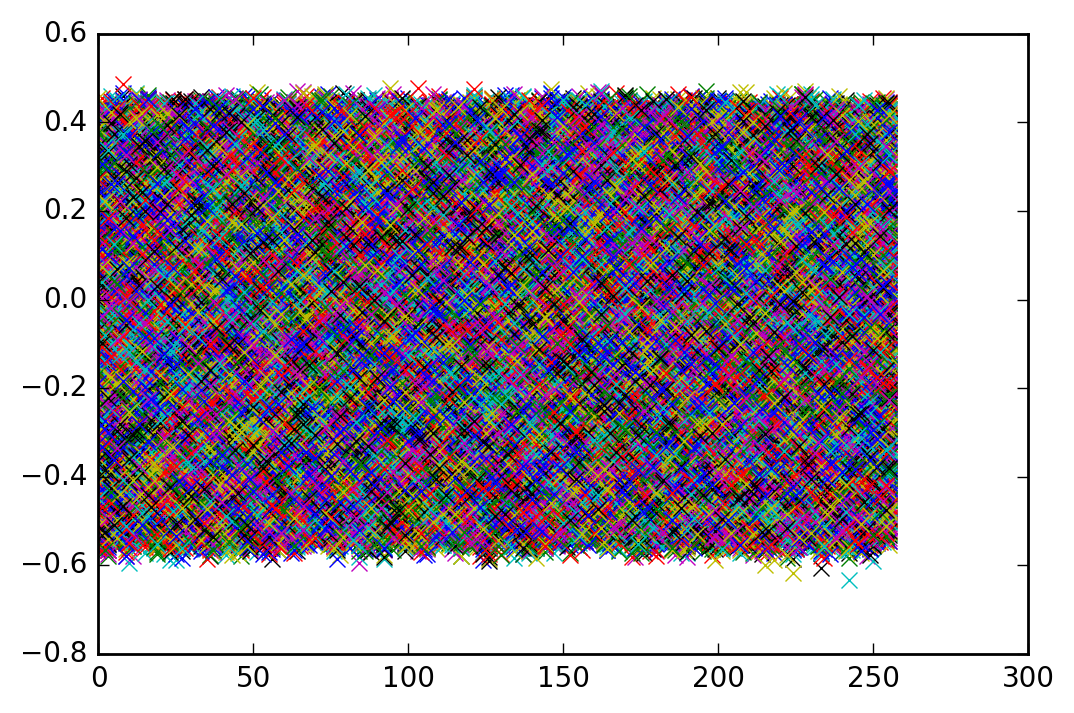

In [103]:
import copy
myWeightsCopy = copy.deepcopy(myWeights[:])
plt.figure()
plt.plot(myWeightsCopy[0],'o')
plt.show()
if(1):
    print(np.shape(myWeights[0]))
    for ck in range(len(myWeights)):
        for c in range(len(myNewWeights1[ck])):
            for k in range(len(myNewWeights1[ck][c])):
                if np.abs(myWeightsCopy[ck][c][k]) <=1.5e-1:
                    myWeightsCopy[ck][c][k] = 0
        
plt.figure()
plt.plot(myWeightsCopy[0],'x')
plt.show()
plt.figure()
plt.plot(myWeightsCopy[1],'x')
plt.show()
plt.figure()
plt.plot(myWeights[0],'x')
plt.show()
plt.figure()
plt.plot(myWeights[1],'x')
plt.show()



(512,)
(192, 256)


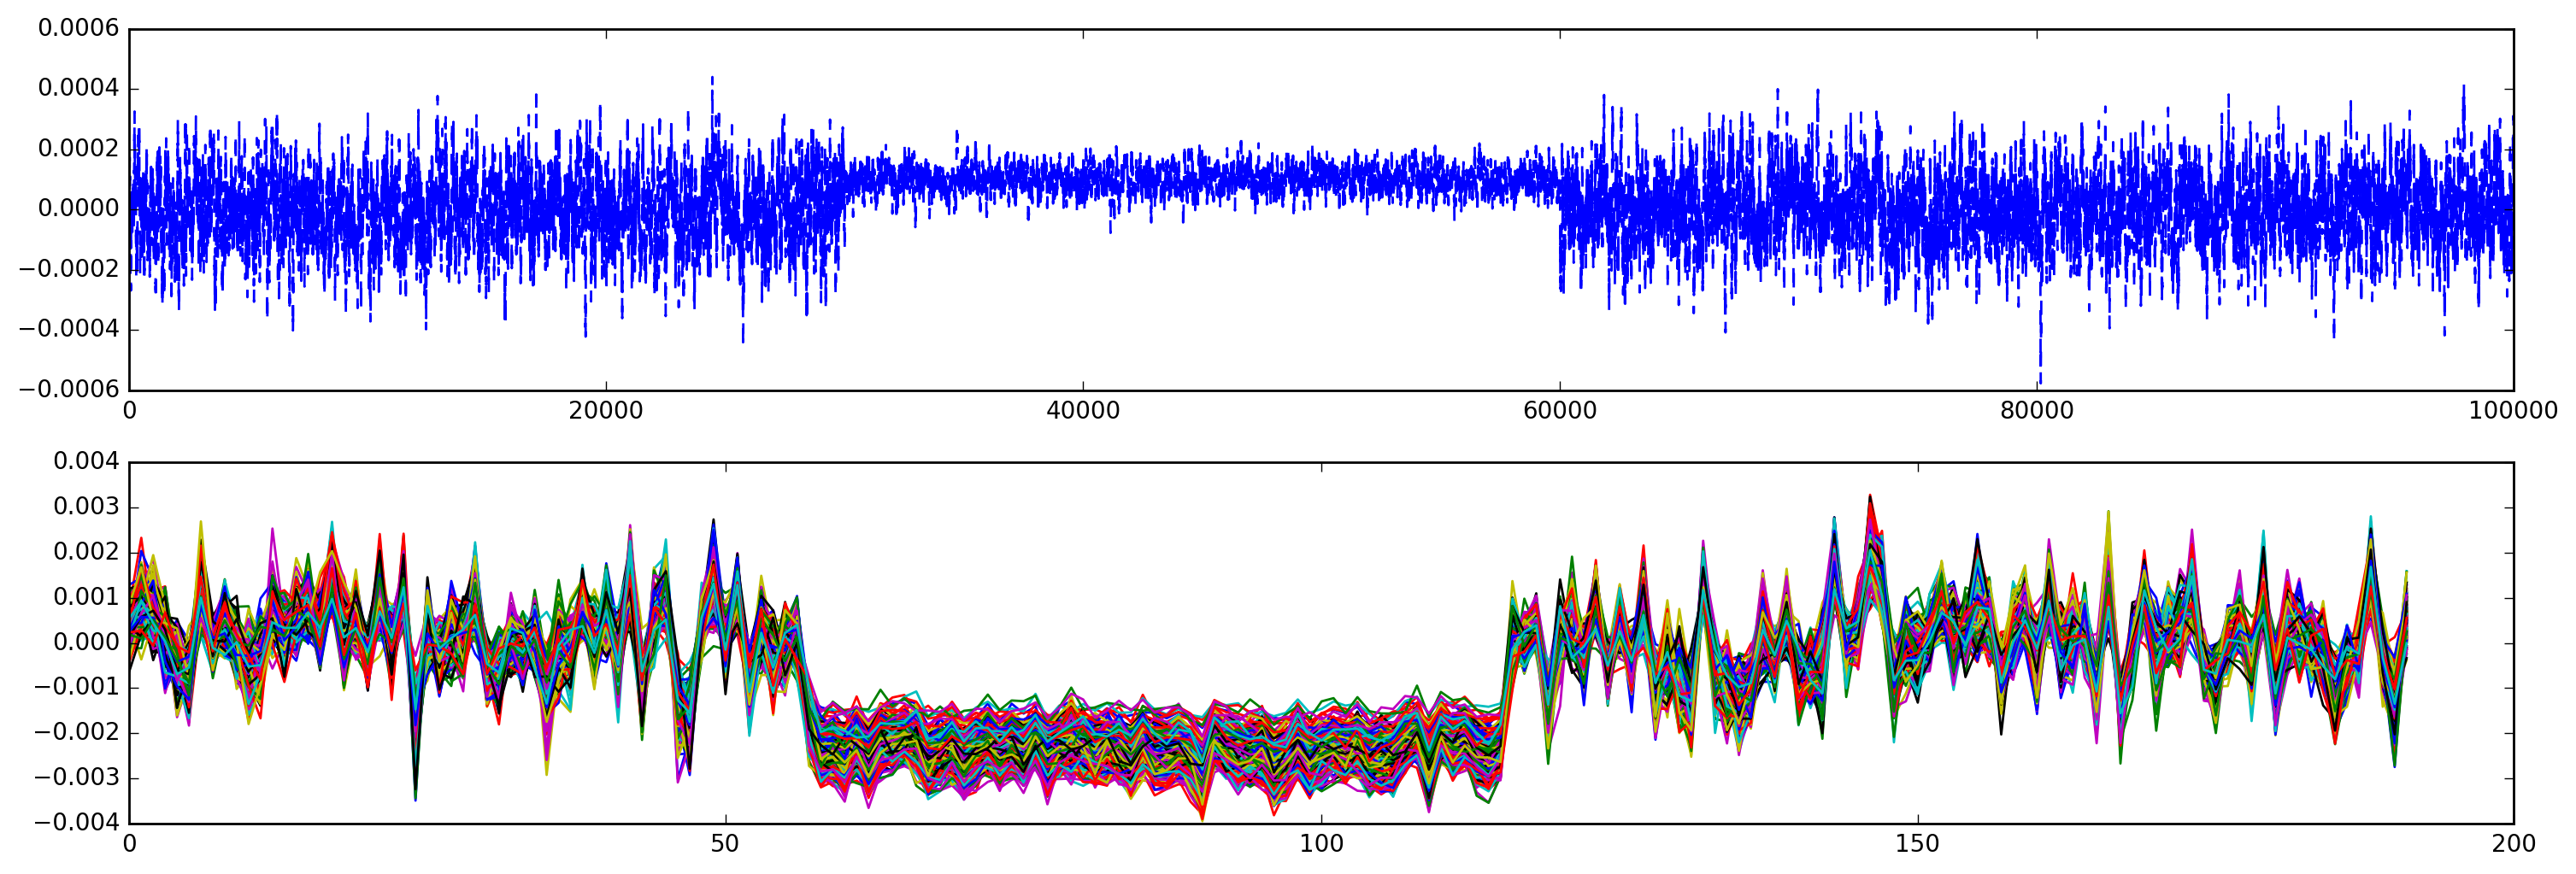

In [105]:
myNewWeights = myWeightsCopy#1024x256
plt.figure()
Z = []
if(1):
    k=0
    a0Rec, zn =forProp(np.array([x[k:k+myWind]]).T,myNewWeights)
    yOut1 = np.array(a0Rec[1])
    print(np.shape(yOut1))
    for k in range(myWind,myLength-myWind-myStride,myWind):#myLength-myWind,myWind):
        #print(k)
        a0Rec, zn =forProp(np.array([x[k:k+myWind]]).T,myNewWeights)
        Z.append(zn[0])
        #print(np.shape(zn[3]))
        #print(np.shape(yOut1))
        #print(np.shape(a0Rec[1]))
        yOut1 = np.append(yOut1,a0Rec[1],0)
#print(np.shape(x))
#print(np.shape(yOut1))
#print(np.shape(Z[0]))
myFig, myAx = plt.subplots(2,1,figsize=(18,6))
myAx[0].plot(x[0:287000],'--')
print(np.shape(Z))
myAx[1].plot((Z[:]))
#myAx[1].plot(([np.array(Z)[:,0]))
#myAx[1].plot(yOut1[0:287000],'--')
#print(np.shape(Z))
plt.show()

In [222]:
%store myNewWeights1
%store myWeights

Stored 'myNewWeights1' (list)
Stored 'myWeights' (list)
